In [30]:
%load_ext autoreload
%autoreload 2

import numpy as np
from sklearn.neighbors import KernelDensity
from sklearn.linear_model import LogisticRegression
import pandas as pd
import torch
from glob import glob

from py.Dataset import Dataset
from py.FileUtils import load
from py.PlotUtils import plot_roc_curve, get_percentiles
from py.PyTorchData import get_log, create_dataloader, model_output_to_image
from py.Labels import LABELS
from py.Autoencoder2 import Autoencoder
from py.ImageUtils import display_images

DIR = '/home/kleinsteuber/vscode/ResizedSessions256_NoBackup' # dataset directory
SESSION = "beaver_01"
TRAIN_NAME = "ae2_deep_noise_sparse"

ds = Dataset(DIR)
session = ds.create_session(SESSION)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Found 2 sessions
Session 'Beaver_01' at folder: /home/kleinsteuber/vscode/ResizedSessions256_NoBackup/VIELAAS_Spring_Session01-VIELAAS_Beaver_01
Loaded scans.


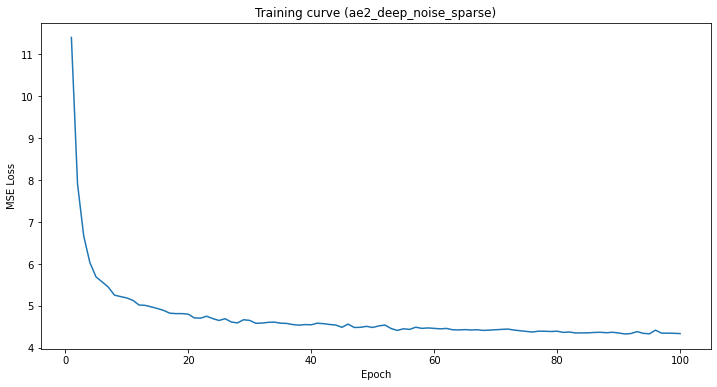

In [21]:
its, losses = get_log(TRAIN_NAME, display=True)

In [28]:
model_path = sorted(glob(f"./ae_train_NoBackup/{TRAIN_NAME}/model_*.pth"))[-1]
model = Autoencoder()
model.load_state_dict(torch.load(model_path, map_location=torch.device("cpu")))
model.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (5): ReLU(inplace=True)
    (6): Dropout(p=0.1, inplace=False)
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): Dropout(p=0.1, inplace=False)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Dropout(p=0.1, inplace=False)
    (13): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): Dropout(p=0.1, inplace=False)
    (16): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (17): ReLU(inplace=True)
    (18): Dropout(p=0.1, inplace=False)
    (19): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1),

In [29]:
def labeler(filename: str) -> int:
    is_normal = (int(filename[10:-4]) in LABELS[session.name]["normal"])
    return 0 if is_normal else 1

def is_labeled(filename: str) -> bool:
    return int(filename[10:-4]) <= LABELS[session.name]["max"]

test_dl = create_dataloader(session.get_motion_folder(), shuffle=False, labeler=labeler, filter=is_labeled, skip_transforms=True)

695 files found


In [31]:
features, labels = next(iter(test_dl))
print(f"Feature batch shape: {features.size()}")
print(f"Labels batch shape: {labels.size()}")
input_imgs = model_output_to_image(features).detach()
output_imgs = model_output_to_image(model(features)).detach()

Feature batch shape: torch.Size([32, 3, 256, 256])
Labels batch shape: torch.Size([32])


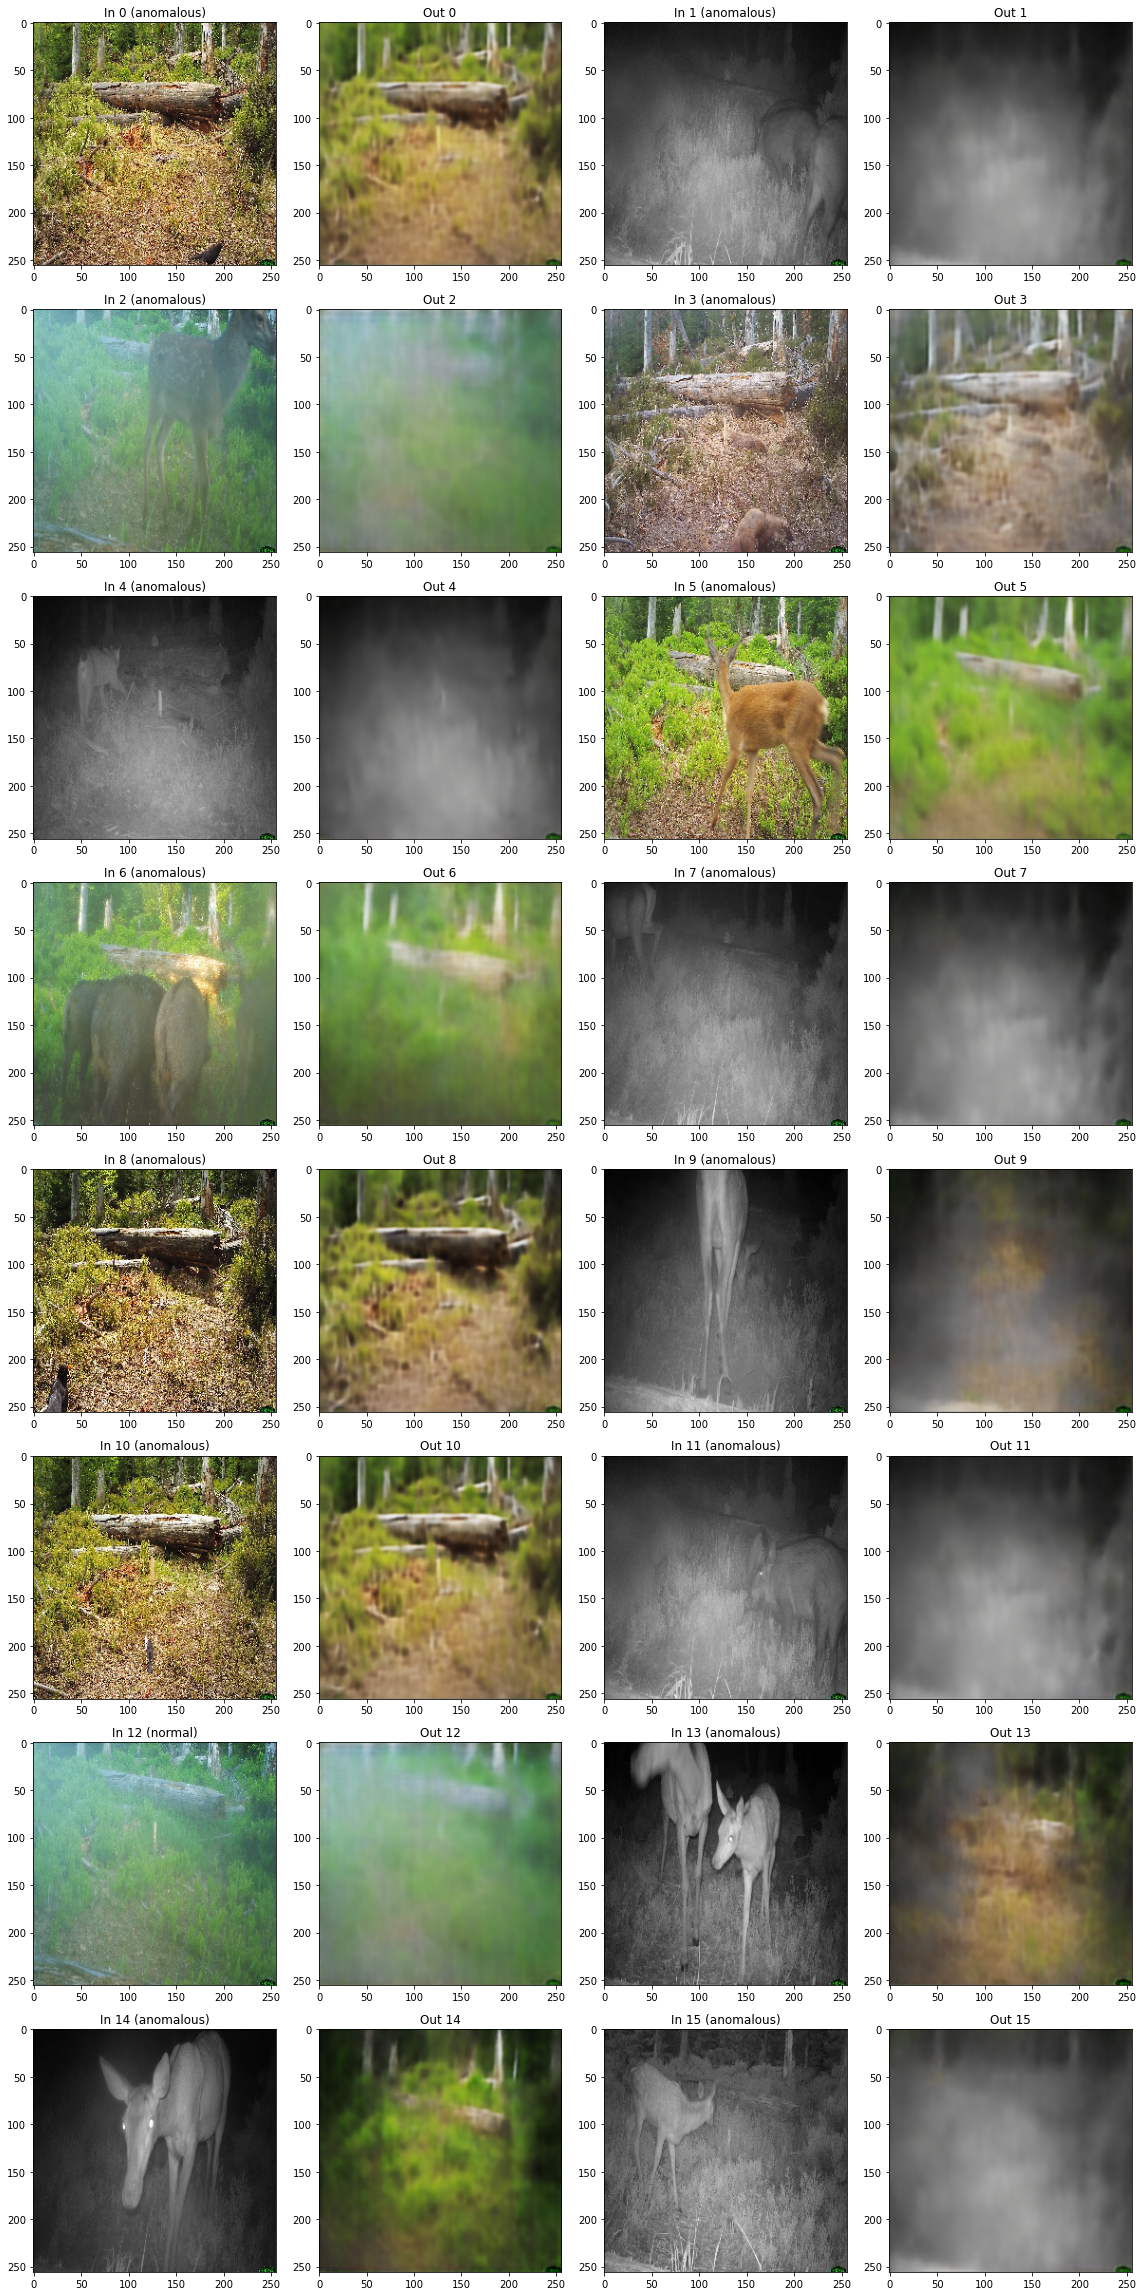

In [33]:
dimgs = []
dlbls = []
only_normals = False
for i in range(32 if only_normals else 16):
    if only_normals and labels[i] == 1:
        continue
    lbl = "anomalous" if labels[i] == 1 else "normal"
    dimgs += [np.einsum("ijk->jki", input_imgs[i]), np.einsum("ijk->jki", output_imgs[i])]
    dlbls += [f"In {i} ({lbl})", f"Out {i}"]
display_images(dimgs, dlbls, size=(4, 4), row_size=4)

In [3]:
lapse_losses, lapse_encodings, lapse_labels = load(f"./ae_train_NoBackup/{TRAIN_NAME}/eval/{session.name}_lapse.pickle")
motion_losses, motion_encodings, motion_labels = load(f"./ae_train_NoBackup/{TRAIN_NAME}/eval/{session.name}_motion.pickle")

In [4]:
kde = KernelDensity(kernel="gaussian", bandwidth=0.2).fit(lapse_encodings)

In [5]:
preds = kde.score_samples(motion_encodings)
y_anom = preds[motion_labels == 1]
y_norm = preds[motion_labels == 0]

In [6]:
pd.Series(y_norm).describe()

count    7.400000e+01
mean    -2.073727e+07
std      6.007246e+07
min     -3.089760e+08
25%     -1.017565e+07
50%     -7.924425e+06
75%     -2.720522e+06
max      3.167954e+02
dtype: float64

In [7]:
pd.Series(y_anom).describe()

count    6.210000e+02
mean    -2.110057e+08
std      3.090626e+08
min     -1.801623e+09
25%     -1.874621e+08
50%     -7.601582e+07
75%     -4.367579e+07
max     -7.580517e+05
dtype: float64

In [17]:
mode = "kde"

if mode == "kde":
    y_anom = preds[motion_labels == 1]
    y_norm = preds[motion_labels == 0]
    X = np.concatenate([y_norm, y_anom]).reshape((-1, 1))
    y = np.concatenate([-np.ones_like(y_norm), np.ones_like(y_anom)])
elif mode == "loss":
    y_anom = motion_losses[motion_labels == 1]
    y_norm = motion_losses[motion_labels == 0]
    X = np.concatenate([y_norm, y_anom]).reshape((-1, 1))
    y = np.concatenate([-np.ones_like(y_norm), np.ones_like(y_anom)])
else:
    raise ValueError("unknown mode")


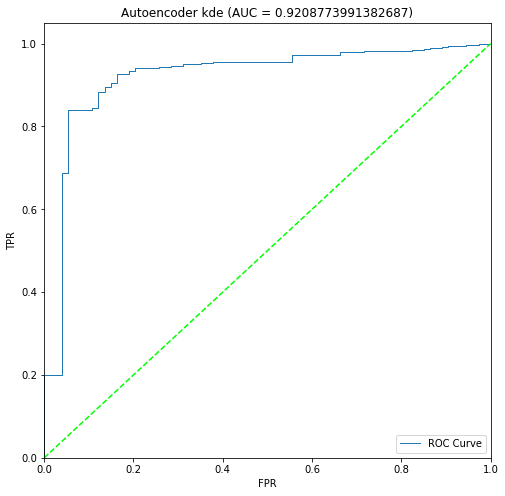

0.9 percentile : TPR = 0.9050, FPR = 0.1486 <-> TNR = 0.8514 @ thresh 17550323.86403683
0.95 percentile : TPR = 0.9517, FPR = 0.3108 <-> TNR = 0.6892 @ thresh 8964006.018924074
0.98 percentile : TPR = 0.9807, FPR = 0.6892 <-> TNR = 0.3108 @ thresh 2973684.7084381217
0.99 percentile : TPR = 0.9903, FPR = 0.8784 <-> TNR = 0.1216 @ thresh 1865040.012273987


In [19]:
fpr, tpr, thresholds, auc_score = plot_roc_curve(y, -X[:,0], f"Autoencoder {mode}", savefile=f"plots/approach4/roc_curves/{session.name}_{mode}")
get_percentiles(fpr, tpr, thresholds)

## AUC Scores

### Beaver_01

| Mode | AUC |
| --- | ---: |
| Loss | 0.5549 |
| KDE | 0.9209 |
| KDE + Loss | 0.9209 |

### Marten_01

| Mode | AUC |
| --- | ---: |
| Loss | 0.8499 |
| KDE | 1.0 |
| KDE + Loss | 1.0 |